In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy
from copy import deepcopy
from sklearn.metrics import r2_score
from data import MassMapsDatasetFilteredS8 as MassMapsDataset
from data import RandomToTensor
import data
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms.functional as F
import random
from os.path import join as oj
plt.style.use('dark_background')
out_dir = '/scratch/users/vision/data/cosmo/'

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# download / extract data

In [79]:
!gsutil ls gs://massivenu
folders = ['z1_256b', 'z1_256b_test']

gs://massivenu/cosmological_parameters.txt
gs://massivenu/resnet18
gs://massivenu/resnet18_state_dict
gs://massivenu/models_feb20/
gs://massivenu/z1_256/
gs://massivenu/z1_256b/
gs://massivenu/z1_256b_test/


In [80]:
!ls {out_dir}

cosmological_parameters.txt  resnet18_state_dict  z1_256   z1_256b_test
resnet18		     results		  z1_256b


In [ ]:
# First step, download data, it takes a few minutes....
# ! gsutil -m cp -r gs://massivenu/cosmological_parameters.txt {out_dir}
# for folder in folders:
#     ! gsutil -m cp -r {'gs://massivenu/' + folder} {out_dir}

In [81]:
%%bash
# Second step, extract data, that also takes a few minutes
# ! cd z1_256b ; for m in model*.tar.gz; do tar -xzf $m ; rm $m ; done;
cd '/scratch/users/vision/data/cosmo/z1_256b_test'
# for m in model*.tar.gz
# do
#     tar -xzf $m
#     rm $m
# done

# make dset

In [2]:
data_transform = transforms.Compose([RandomToTensor()])
param_file = oj(out_dir, 'cosmological_parameters.txt')
mnu_dataset = MassMapsDataset(param_file,  
                              root_dir=oj(out_dir, 'z1_256b'),
                              transform=data_transform)
mnu_dataset_test = MassMapsDataset(param_file,
                              root_dir=oj(out_dir, 'z1_256b_test'),
                              transform=data_transform)

**look at some ims**

In [ ]:
figure(figsize=(15,15))
mes = []
s8 = []
om = []
for i in range(len(mnu_dataset)):
    sample = mnu_dataset[i]
    #print(i, sample['image'].shape, sample['params'].shape)

    subplot(5, 5, i + 1)
    tight_layout()
    axis('off')
    imshow(squeeze(sample['image']), cmap='magma',vmin=-0.1,vmax=0.15)
    title(r"$M_\nu=%0.2f ; \Omega_m$=%0.2f; $\sigma_8=%0.2f$"%(sample['params'][0],sample['params'][1],sample['params'][2] ) )
    s8.append(sample['params'][2].numpy())
    om.append(sample['params'][1].numpy())
    mes.append(np.std(sample['image'].numpy()))
    if i == 24:
        break

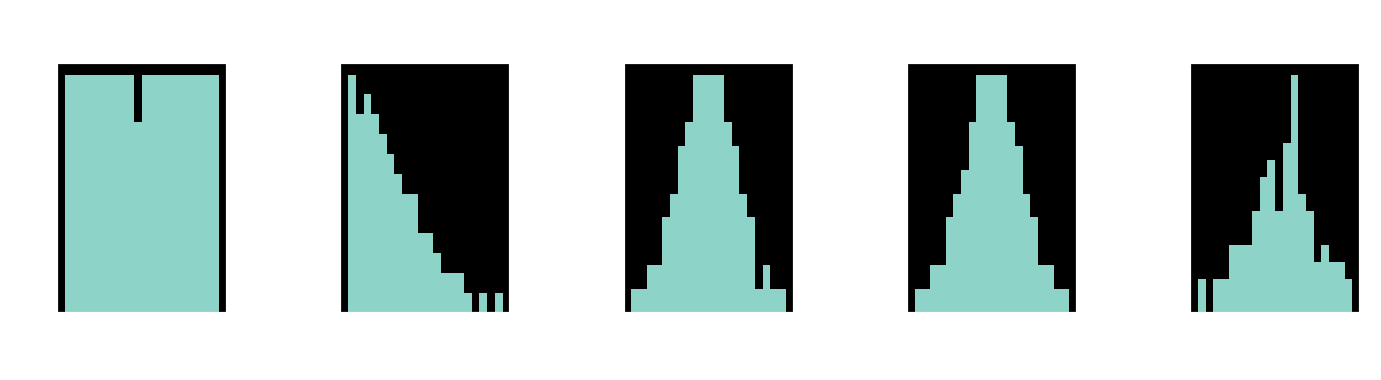

In [13]:
params = mnu_dataset.params
R, C = 1, 5
plt.figure(dpi=200, figsize=(7, 2))
for i in range(5):
    plt.subplot(R, C, i + 1)
    plt.hist(params[:, i], bins=20)
    plt.title(data.classes[i])
plt.tight_layout()

## Train a model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Modifying the model to predict the three cosmological parameters from single channel images
model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

In [5]:
# data_transform = transforms.Compose([
#         ToTensor()
#     ])

In [6]:
# mnu_dataset = MassMapsDataset('cosmological_parameters.txt',
#                               'z1_256b', 
#                               transform=data_transform)

dataloader = torch.utils.data.DataLoader(mnu_dataset, batch_size=128, 
                                         shuffle=True, num_workers=4)
dataloader_test = torch.utils.data.DataLoader(mnu_dataset_test, batch_size=128, 
                                         shuffle=False, num_workers=4)

In [7]:
def train_model(model, dataloader_train, dataloader_test, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e10
    train_losses = []
    test_losses = []
    learning_rates= []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = dataloader_train
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = dataloader_test

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloader:
                inputs, params = data['image'], data['params']
                inputs = inputs.to(device)
                params = params.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, params)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    test_losses.append(loss.item())
            if phase == 'train':
                scheduler.step()
                learning_rates.append(scheduler.get_lr())

            epoch_loss = running_loss / len(mnu_dataset)
            
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            
            if epoch_loss <= best_loss:
                torch.save(deepcopy(model_ft.state_dict()), oj(out_dir, f'resnet18_full_state_dict_{epoch}.pkl'))
            best_loss = min(epoch_loss, best_loss)
            
            
            # save
            # Saving fairly well trained model
            
            # # deep copy the model
            # if phase == 'val' and epoch_loss < best_loss:
            #     best_loss = epoch_loss
            #     best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, learning_rates

In [8]:
criterion = torch.nn.L1Loss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
model_ft, loss_trace, lr_trace = train_model(model_ft, dataloader, dataloader_test,
                                             criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


In [ ]:
# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

In [ ]:
# model_ft, loss_trace2, lr_trace2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
# analyze model

In [ ]:
plot(loss_trace2[100:])

In [ ]:
plot(lr_trace2)
yscale('log')

In [ ]:
with torch.no_grad():
    for data in dataloader:
        inputs, params = data['image'], data['params']
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model_ft(inputs)
        break

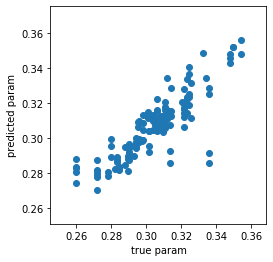

In [ ]:
scatter(params.cpu()[:,1], outputs.cpu()[:,1])
xlabel('true param')
ylabel('predicted param')
#ylim(0.265,0.35)
#xlim(0.265,0.35)
gca().set_aspect('equal')

In [ ]:
coefficient_of_dermination = r2_score(params.cpu()[:,1], outputs.cpu()[:,1])

In [ ]:
coefficient_of_dermination

0.7257992068325176

In [ ]:
# Saving fairly well trained model
torch.save(model_ft.state_dict(), 'resnet18_state_dict')

In [ ]:
torch.save(model_ft, 'resnet18')

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil cp resnet18* gs://massivenu/models_feb20/

Copying file://resnet18 [Content-Type=application/octet-stream]...
Copying file://resnet18_state_dict [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/85.4 MiB.                                     


In [ ]:
!gsutil ls gs://massivenu/z1_256b_test